<a href="https://colab.research.google.com/github/LEEJungHoon2022/ML-DL/blob/ML-DL/Dacon_shopping_mall-01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install konlpy

In [1]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/shopping_mall/'

train_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'test.csv')
submmision = pd.read_csv(data_path + 'sample_submission.csv')

In [5]:
train_data.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   target   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [ ]:
test_data.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


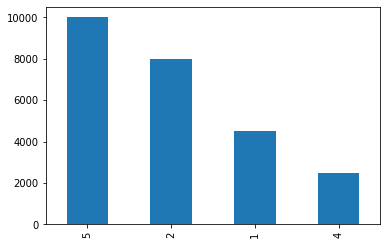

In [ ]:
train_data.target.value_counts().plot(kind='bar');

In [ ]:
train_data.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [ ]:
print(train_data['reviews'].nunique())
print(train_data['target'].nunique())

24999
4


train_data.loc[train_data.duplicated(subset=['reviews'], keep=False)] # 중복값 발견, target은 다름 처음에는 처리안하고 진행

## 원본데이터 보존

In [28]:
all_data = train_data.copy()
print(len(all_data))
all_data.head()

25000


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [29]:
train_data['label'] = np.select([train_data.target > 3], [1], default=0)
train_data[:5]

,id,reviews,target,label
0,0,조아요 처음구입 싸게햇어요,2,0
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,0
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,0
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,0
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,1


In [30]:
train_data, test_data = train_test_split(train_data, test_size = 0.25, random_state=42)
print('train data 의 수 :', len(train_data))
print('test data  의 수 :',  len(test_data))

train data 의 수 : 18750
test data  의 수 : 6250


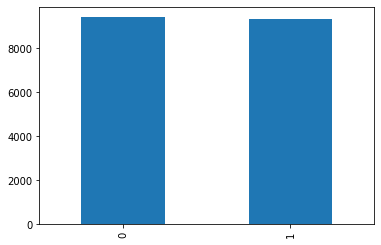

In [32]:
train_data.label.value_counts().plot(kind='bar');

In [33]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id         0
reviews    0
target     0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [34]:
train_data.head()

,id,reviews,target,label
6920,6920,깻잎은 그냥저냥 보통인거 같아요 조금 질긴 감은 있지만 양념도 괜찮아요,4,1
17926,17926,재구매 상세설명과 같고 사용하기 넘 편해요,4,1
1123,1123,재구매 배송도 너무 느리고 전복이 너무 작아요,2,0
4518,4518,배송은빨랐어요 컬러는생각보다어둡네요 디자인도이쁘고크기도딱좋은데 미끄럼방지가아쉽네요 ...,5,1
5576,5576,좋아유 잘잡혀유ㅋㅋ,5,1


In [35]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 6250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [36]:
# train = train.drop('id',axis=1)
# train.reviews.apply(lambda x : x.split())
train_data.reviews

6920               깻잎은 그냥저냥 보통인거 같아요 조금 질긴 감은 있지만 양념도 괜찮아요
17926                              재구매 상세설명과 같고 사용하기 넘 편해요
1123                             재구매 배송도 너무 느리고 전복이 너무 작아요
4518     배송은빨랐어요 컬러는생각보다어둡네요 디자인도이쁘고크기도딱좋은데 미끄럼방지가아쉽네요 ...
5576                                            좋아유 잘잡혀유ㅋㅋ
                               ...                        
21575                         년째닭가슴살먹는중인데 씹어먹기에는 힘들듯갈아마시는중
5390                                      깨끗하게 털이 없어지진 않네요
860                                               몇년째 사용해요
15795                                       ㄱㅊ네여 뱌송상태 좋습니다
23654    그냥 싼거 다이소 보다 못합니다 거치대는 진짜 무쓸모 그리고 모기잡기가 너무 무거움...
Name: reviews, Length: 18750, dtype: object

In [ ]:
texts = train_data['reviews']
reviews = ''

for text in texts:
    reviews += text
    
print(len(reviews))

713311


In [37]:
mecab = Mecab()
# mecab.morphs(reviews[:1000])

In [38]:
stopwords = ['은','거','죠','도','과','고','기','이','는','가','거의','심','유','었','습니다','를','었','고요','어요','어서','게','진','네요', '이게','라','는데']

In [39]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [40]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [41]:
test_data.head()

,id,reviews,target,label,tokenized
6868,6868,중인데 너무 얇습니다 끈도 길고 마스크도 너무 뻣뻣해서 저는 밀착이 잘 안 됩니다 ...,2,0,"[중, 인데, 너무, 얇, 끈, 길, 마스크, 너무, 뻣뻣, 해서, 저, 밀착, 잘..."
24016,24016,끝물이라고는 하지만 개 서비스로 더 왔고 그거 제외하고 개가 완전 마르고 알도없어서...,1,0,"[끝물, 라고, 하지만, 개, 서비스, 로, 더, 왔, 그거, 제외, 하, 개, 완..."
9668,9668,체리블러썸은 사랑이죠,5,1,"[체리, 블러, 썸, 사랑]"
13640,13640,아의자 육각이가 자꾸 돌릴때마다 무뎌져서 힘들었고요 ㅠ 생각보다견고한느낌이아니에요 ...,2,0,"[아, 의자, 육, 각이, 자꾸, 돌릴, 때, 마다, 무뎌, 져서, 힘들, ㅠ, 생..."
14018,14018,나박김치 야채가 싱싱하지 않아서 실망 했어요,2,0,"[나박김치, 야채, 싱싱, 하, 지, 않, 아서, 실망, 했어요]"


In [42]:
train_data.head()

,id,reviews,target,label,tokenized
6920,6920,깻잎은 그냥저냥 보통인거 같아요 조금 질긴 감은 있지만 양념도 괜찮아요,4,1,"[깻잎, 그냥저냥, 보통, 인, 같, 아요, 조금, 질긴, 감, 있, 지만, 양념,..."
17926,17926,재구매 상세설명과 같고 사용하기 넘 편해요,4,1,"[재, 구매, 상세, 설명, 같, 사용, 하, 넘, 편해요]"
1123,1123,재구매 배송도 너무 느리고 전복이 너무 작아요,2,0,"[재, 구매, 배송, 너무, 느리, 전복, 너무, 작, 아요]"
4518,4518,배송은빨랐어요 컬러는생각보다어둡네요 디자인도이쁘고크기도딱좋은데 미끄럼방지가아쉽네요 ...,5,1,"[배송, 빨랐, 컬러, 생각, 보다, 어둡, 디자인, 이쁘, 크, 딱, 좋, 은데,..."
5576,5576,좋아유 잘잡혀유ㅋㅋ,5,1,"[좋, 아유, 잘, 잡혀, ㅋㅋ]"


In [52]:
train_data[train_data.label == 1]['tokenized']

6920     [깻잎, 그냥저냥, 보통, 인, 같, 아요, 조금, 질긴, 감, 있, 지만, 양념,...
17926                    [재, 구매, 상세, 설명, 같, 사용, 하, 넘, 편해요]
4518     [배송, 빨랐, 컬러, 생각, 보다, 어둡, 디자인, 이쁘, 크, 딱, 좋, 은데,...
5576                                    [좋, 아유, 잘, 잡혀, ㅋㅋ]
14265    [엄청, 맛있, 먹, 샤브샤브, 용, 소고기, 조금, 넣, 어, 끊이, 니, 더, ...
                               ...                        
4426                  [재, 구매, 만족, 합니다, 배송, 빠르, 가격, 저렴, 해요]
16850                 [좋, 작동, 잘, 괴구, 요, 낸, 오에, 주, ㅏ티오누ㅠㅊ에]
11964            [감자, 작, 아도, 푹신푹신, 맛있, 쩌, 먹, 크, 적당, 하, 맛있]
860                                      [몇, 년, 째, 사용, 해요]
15795                                    [ㄱ, ㅊ네여, 뱌송상태, 좋]
Name: tokenized, Length: 9344, dtype: object

In [47]:
label_0 = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
label_1 = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [53]:
label_0_word_count = Counter(label_0)
label_1_word_count = Counter(label_1)

In [54]:
print(label_0_word_count.most_common(20))

[('하', 3813), ('에', 2992), ('안', 2567), ('있', 1705), ('너무', 1601), ('했', 1486), ('지', 1447), ('을', 1380), ('한', 1363), ('다', 1244), ('좋', 1240), ('배송', 1227), ('구매', 1150), ('없', 1116), ('같', 1102), ('되', 1096), ('어', 1083), ('아요', 1081), ('잘', 1051), ('그냥', 1038)]


In [55]:
print(label_1_word_count.most_common(20))

[('좋', 4914), ('하', 4037), ('아요', 2621), ('에', 2534), ('잘', 2377), ('구매', 2031), ('있', 1593), ('배송', 1534), ('먹', 1222), ('합니다', 1197), ('했', 1196), ('재', 1153), ('너무', 1075), ('같', 1004), ('한', 964), ('만족', 918), ('쓰', 833), ('을', 797), ('아', 794), ('어', 793)]


label_0 의 평균 길이 : 17.23240484796938
label_1의 평균 길이 : 13.667487157534246


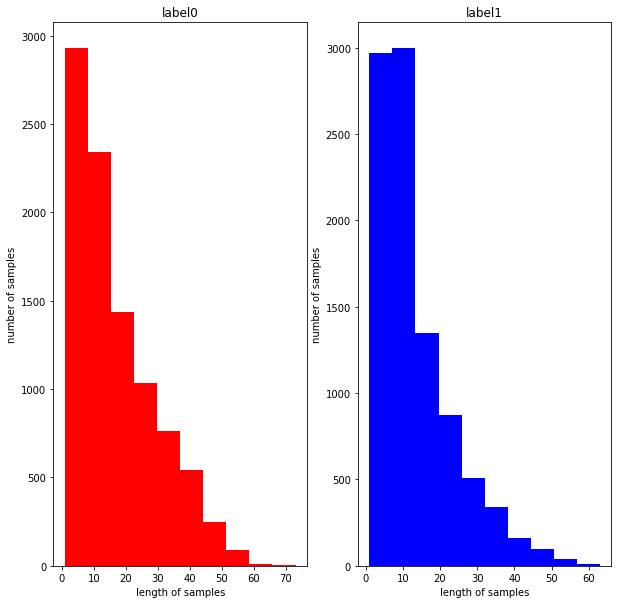

In [58]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
text_len0 = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len0, color='red')
ax1.set_title('label0')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('label_0 의 평균 길이 :', np.mean(text_len0))

text_len1 = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len1, color='blue')
ax2.set_title('label1')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('label_1의 평균 길이 :', np.mean(text_len1))

plt.show()

### 평점이 낮을 수록 리뷰의 평균 길이가 길어짐

In [59]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values1

In [63]:
y_test[:5]

array([0, 0, 1, 0, 0])

### 정수 인코딩

In [64]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [65]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15187
등장 빈도가 1번 이하인 희귀 단어의 수: 7112
단어 집합에서 희귀 단어의 비율: 46.82952525186014
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.4541316852831465


In [66]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 8077


In [67]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [68]:
print(X_train[:3])

[[5969, 1319, 763, 120, 15, 5, 105, 4219, 193, 7, 39, 817, 84, 5], [22, 8, 1629, 644, 15, 32, 2, 87, 335], [22, 8, 10, 12, 556, 3298, 12, 75, 5]]


In [69]:
print(X_test[:3])

[[128, 103, 12, 185, 530, 165, 689, 12, 1124, 30, 127, 2901, 6, 9, 332, 133, 2, 181, 28, 45, 32, 20], [1, 173, 760, 63, 485, 29, 56, 74, 1359, 2543, 2, 63, 131, 1840, 115, 25, 284, 457, 199, 149, 205, 59, 4247, 197, 168, 9, 921, 27, 15, 5], [4081, 7247, 7626, 2909]]


리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 15.45584


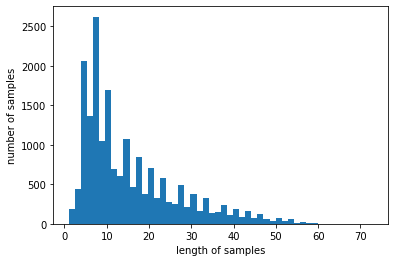

In [70]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [72]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 99.99466666666666


In [73]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [74]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.3737 - acc: 0.8453
Epoch 1: val_acc improved from -inf to 0.74827, saving model to best_model.h5
235/235 [==============================] - 32s 124ms/step - loss: 0.3737 - acc: 0.8453 - val_loss: 0.6809 - val_acc: 0.7483
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.2615 - acc: 0.9017
Epoch 2: val_acc improved from 0.74827 to 0.88240, saving model to best_model.h5
235/235 [==============================] - 29s 124ms/step - loss: 0.2615 - acc: 0.9017 - val_loss: 0.3006 - val_acc: 0.8824
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.2313 - acc: 0.9147
Epoch 3: val_acc improved from 0.88240 to 0.88907, saving model to best_model.h5
235/235 [==============================] - 29s 122ms/step - loss: 0.2313 - acc: 0.9147 - val_loss: 0.2933 - val_acc: 0.8891
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.2107 - acc: 0.9240
Epoch 4: val_acc did not

In [75]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

196/196 [==============================] - 4s 18ms/step - loss: 0.2743 - acc: 0.8957

 테스트 정확도: 0.8957
